# NLSA Application with complete Daily data

This notebook is still a work in progress. All functions should be used from /scripts

In [1]:
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
import numpy as np
import warnings
import scripts.helper as helper
import scripts.matrix_helper
from tqdm import tqdm_notebook
from scipy import signal
from scipy.sparse import hstack
from scipy.sparse import save_npz
from scipy.sparse import load_npz
from scipy.sparse import lil_matrix
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy.sparse import identity
from scipy.sparse import diags

from mpl_toolkits.basemap import Basemap

#Cool stuff -> Every notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
n_batches = 17
batch_size = 5000

In [ ]:
res = []
res.append(1.0)
for b in range(n_batches):
    d0 = np.load('scripts/dataFull/D_mat_5000_' + str(b) + '.npy', mmap_mode='r')
    d0 = d0[:-1, :]
    dim = d0.shape[1]
    if b <  n_batches - 1:
        dim = dim + 1
    for i in tqdm_notebook(range(1, dim)):
        res.append(d0[i + (b*dim), i-1])
print(len(res))
np.save('scripts/dataFull/phi_vector_5000', res)

### Select K-Closest indexes Batch

In [3]:
def select_k_closest_batches(k, name, n_batches, b_size):
    for b in tqdm_notebook(range(n_batches)):
        d0 = np.load(name + str(b) + '.npy', mmap_mode='r')
        res = np.zeros(d0.shape)
        dim = d0.shape[1]
        for i in range(dim):
            k_indx = sorted(np.argpartition(d0[:, i], k)[:k])
            res[k_indx, [i] * k] = d0[k_indx, [i] * k]       
        np.save('k_closest_5000_8k_' + str(b), res)
        d0 = None

In [5]:
select_k_closest_batches(8255, 'scripts/dataFull/D_mat_5000_', n_batches, batch_size)

A Jupyter Widget

## NLSA Kernel with Sparse Matrix

In [3]:
def build_nlsa_kernel_batches(name, n_batches, b_size, eps):
    phi_vec = np.load('scripts/dataFull/phi_vector_5000.npy', mmap_mode='r')
    print(len(phi_vec))
    for b in tqdm_notebook(range(n_batches)):
        dist_mat = np.load(name + str(b) + '.npy', mmap_mode='r')
        dist_mat = dist_mat[:-1, :]
        row, col = dist_mat.shape
        dist_mat = np.power(dist_mat, 2)
        for i in range(1, row):
            di = phi_vec[i]
            for j in range(col):  
                dj = phi_vec[j + (b * b_size)]
                dist_mat[i, j] = dist_mat[i, j] / (di*dj)

        indx = np.nonzero(dist_mat)
        dist_mat[indx] = np.exp(-dist_mat[indx]/eps)
        if b == 0:
            np.save('nlsa_kernel_5000_8k_' + str(b), dist_mat[1:, 1:])
        else:
            np.save('nlsa_kernel_5000_8k_' + str(b), dist_mat[1:, :])
        dist_mat = None

In [ ]:
build_nlsa_kernel_batches('k_closest_5000_8k_', n_batches, batch_size, 2.0)

In [8]:
def rebuild_sparse_K(name, n_batches, b_size):
    res = lil_matrix([0, 0])
    for b in tqdm_notebook(range(n_batches)):
        dist_mat = np.load(name + str(b) + '.npy', mmap_mode='r')
        if b == 0:
            res = coo_matrix(dist_mat)
        else:
            res = hstack([res, coo_matrix(dist_mat)])
    save_npz('sparse_5000_8k.npz', res)

In [4]:
def rebuild_sparse_K_b(name, n_batches, b_size):
    res = lil_matrix([0, 0])
    for b in tqdm_notebook(range(15, n_batches)):
        dist_mat = np.load(name + str(b) + '.npy', mmap_mode='r')
        if b == 15:
            res = lil_matrix(dist_mat)
        else:
            res = hstack([res, lil_matrix(dist_mat)])
        dist_mat = None
    save_npz('sparse_5000_8k.npz', res)

In [9]:
rebuild_sparse_K('nlsa_kernel_5000_8k_', n_batches, batch_size)

A Jupyter Widget

In [10]:
K2 = load_npz('sparse_5000_8k.npz')

In [11]:
K2.shape

(82545, 82545)

In [12]:
type(K2)

scipy.sparse.coo.coo_matrix

In [90]:
def build_Laplace_Beltrami_operator_sparse(kernel_mat):
    #Equivalent to kernel_mat = csr_matrix(kernel_mat / (kernel_mat.sum(axis=1)[:, None] * kernel_mat.sum(axis=0)[None, :]))
    # This should stay sparse and fit in memory
    print('start')
    d = diags(1/kernel_mat.sum(axis=1).A.ravel())
    print('sum col')
    e = diags(1/kernel_mat.sum(axis=0).A.ravel())
    print('sum row')
    kernel_mat = d @ kernel_mat
    print('div sum col')
    kernel_mat = kernel_mat @ e
    print('div sum row')
    # Equivalent to kernel_mat = kernel_mat / kernel_mat.sum(axis=1)
    # This should stay sparse and fit in memory
    c = diags(1/kernel_mat.sum(axis=1).A.ravel())
    print('2 sum col')
    kernel_mat = c @ kernel_mat
    print('2 div sum col')
    # This should stay sparse and fit in memory
    #return 
    kernel_mat = identity(kernel_mat.shape[0]) - kernel_mat
    print('apply P')
    return kernel_mat

In [91]:
L2 = build_Laplace_Beltrami_operator_sparse(K2)

start
sum col
sum row
div sum col
div sum row
2 sum col
2 div sum col
apply P


In [75]:
L2.shape

(82545, 82545)

In [ ]:
#def build_Laplace_Beltrami_operator_sparse_opti(kernel_mat):
#Equivalent to kernel_mat = csr_matrix(kernel_mat / (kernel_mat.sum(axis=1)[:, None] * kernel_mat.sum(axis=0)[None, :]))
# This should stay sparse and fit in memory
print('start')
d = K2.sum(axis=1).ravel()
print('sum row')
e = K2.sum(axis=0).ravel()
print('sum col')
arr = np.zeros(K2.data.shape[0])
for pos, i, j, v in zip(tqdm_notebook(range(K2.data.shape[0])), K2.row, K2.col, K2.data):
    arr[pos] = v / (d[0, i] * e[0, j])
print('k chapeau')

K2 = coo_matrix((arr, (K2.row, K2.col)))
c = K2.sum(axis=1).ravel()
for pos, i, j in zip(tqdm_notebook(range(K2.data.shape[0])), K2.row, K2.col):
    arr[pos] /= c[0, i]
print('P')

#arr *= -1

#print('apply P')
#print(arr.shape, kernel_mat.row.shape, kernel_mat.col.shape)
#result = identity(kernel_mat.shape[0]) - csr_matrix((arr, (kernel_mat.row, kernel_mat.col)))
#save_npz('LB_Op_8k.npz', res)
#kernel_mat = coo_matrix((arr, (kernel_mat.row, kernel_mat.col)))
#return arr
#row = np.concatenate((K.row, np.arange(K.shape[0])))
#col = np.concatenate((K.col, np.arange(K.shape[0])))
#np.save('data_8k', arr)
#np.save('row_8k', row)
#np.save('col_8k', col)
K = coo_matrix((arr, (K.row, K.col)))

In [3]:
P = load_npz('P_8k.npz')

In [4]:
type(P)

scipy.sparse.coo.coo_matrix

In [13]:
for row, col, value in zip(K2.row[:50], K2.col[:50], K2.data[:50]):
    print("({0}, {1}) {2}".format(row, col, value))

(0, 1) 0.6065206287826618
(0, 2) 0.3382490648305754
(0, 3) 0.238514193156625
(0, 4) 0.1888961537918366
(0, 5) 0.1578374922977652
(0, 6) 0.13488009929518868
(0, 7) 0.11612808177761041
(0, 8) 0.10007170439575182
(0, 9) 0.08589964820765542
(0, 10) 0.07366265165420947
(0, 11) 0.06298778871097592
(0, 12) 0.053258008057428585
(0, 13) 0.04448855236742582
(0, 14) 0.03691028903178646
(0, 15) 0.030357576200536522
(0, 16) 0.024695225675949957
(0, 17) 0.019889552540559227
(0, 18) 0.015855024175529187
(0, 19) 0.012511737860841738
(0, 20) 0.009800422984013495
(0, 21) 0.007611844718177925
(0, 22) 0.005861112710881127
(0, 23) 0.004459047718015757
(0, 24) 0.003346140696463983
(0, 25) 0.0024718405161841647
(0, 26) 0.0018051111369209731
(0, 339) 0.0015103696848642368
(0, 340) 0.0020327714440621847
(0, 341) 0.0027046320432061737
(0, 342) 0.0035713198226847154
(0, 343) 0.004698303116494114
(0, 344) 0.006112120709451349
(0, 345) 0.00783920733268457
(0, 346) 0.00994197512462168
(0, 347) 0.012470766374911088


In [5]:
# Eigendecomposition of the Laplacian - keep only the real part
w_k, v_k = eigs(P, k=100, which='LM')

In [6]:
w_k = np.real(w_k)
v_k = np.real(v_k)

In [7]:
indx = np.argsort(w_k)[::-1][:100]
w_k[indx]

array([ 1.        ,  0.96584518,  0.96582175,  0.8868472 ,  0.8868472 ,
        0.84190121,  0.79660226,  0.79582342,  0.78448819,  0.78448   ,
        0.66369667,  0.66357735,  0.66190154,  0.66115192,  0.53144455,
        0.53136539,  0.47960954,  0.47933901,  0.39769155,  0.39759643,
        0.30946911,  0.30946911,  0.27277166,  0.27269628,  0.24117092,
        0.22597264,  0.22535747,  0.1831614 ,  0.1831614 ,  0.17919417,
        0.17919417,  0.16660279,  0.16658872,  0.12681488,  0.12681488,
        0.08910829,  0.08903233,  0.08810674,  0.08810674,  0.08161505,
        0.08161505,  0.05410169,  0.05410169,  0.04723364,  0.04723364,
        0.04266127,  0.04266127,  0.04127487,  0.04127487,  0.03825713,
        0.03825713,  0.03808435,  0.03808435,  0.03269341,  0.03269341,
       -0.02384158, -0.02384158, -0.02542044, -0.02542044, -0.02856502,
       -0.02856502, -0.02908433, -0.02908433, -0.03263701, -0.03263701,
       -0.03275125, -0.03325949, -0.03325949, -0.03333289, -0.03

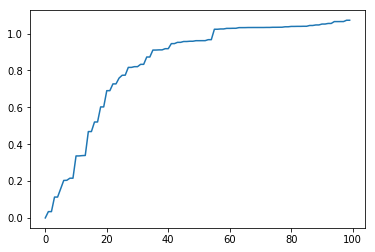

In [8]:
plt.plot(1- w_k[indx])

In [9]:
w_k = w_k[indx]
v_k = v_k[:, indx]

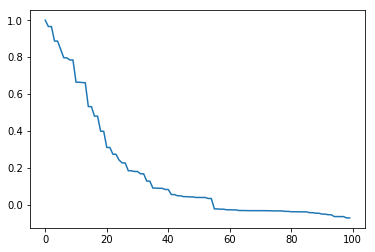

In [10]:
# Eigenvalue plot
#plt.title('First 100 eigenvalues of the Laplace-Beltrami operator')
plt.plot(w_k)
plt.show()

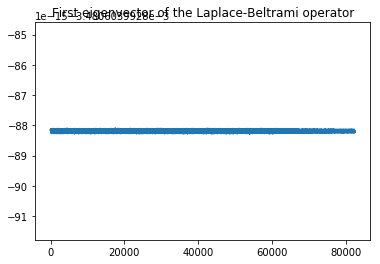

In [12]:
# Eigenvalue plot
plt.title('First eigenvector of the Laplace-Beltrami operator')
plt.plot(v_k[:, 0])
plt.show()

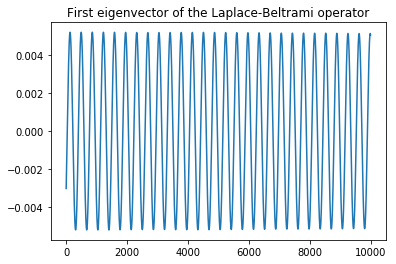

In [13]:
# Eigenvalue plot
plt.title('First eigenvector of the Laplace-Beltrami operator')
plt.plot(v_k[30000:40000, 1])
plt.show()

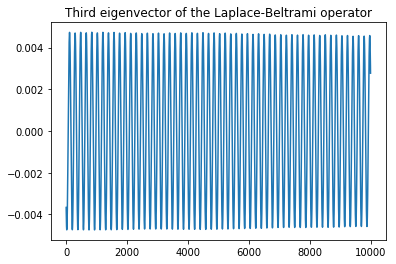

In [14]:
# Eigenvalue plot
plt.title('Third eigenvector of the Laplace-Beltrami operator')
plt.plot(v_k[30000:40000, 3])
plt.show()

## Spatiotemporal patterns analysis

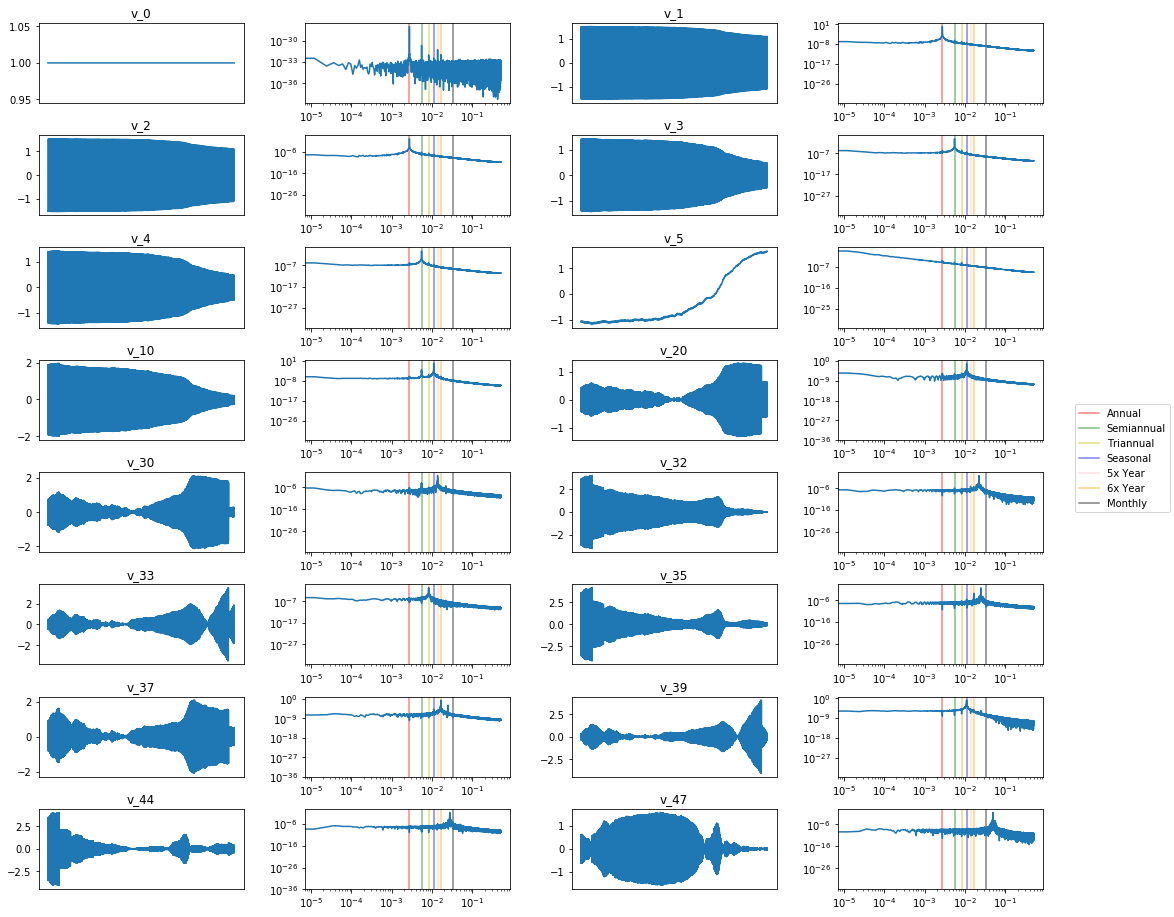

In [15]:
# Frequencies plot
list_vector = [0, 1, 2, 3, 4, 5, 10, 20, 30, 32, 33, 35, 37, 39, 44, 47]
my_xticks = np.arange(1980, 1986, 1)
fig = plt.figure(figsize=(18,18))
ind = 1
for i in list_vector:
    ax = plt.subplot(9, 4, ind)
    #ax.set_xticks(np.arange(0, len(v_k[:, 0]), 365))
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    
    #if i == 44 or i == 47:
    #    ax.set_xticklabels(my_xticks, rotation='70')
    #else:
    #    ax.set_xticklabels(['', '', '', '', '', ''], rotation='70')
        
    ind += 1
    plt.title('v_'+str(i))
    plt.plot(v_k[:, i]/v_k[:, 0])
    
    plt.subplot(9, 4, ind)
    ind += 1
    f, Pxx_den = signal.periodogram(np.real(v_k[:, i]))
    #l1 = plt.axvline(x=1/(365*11), color='grey', alpha=0.5) #11y
    l2 = plt.axvline(x=1/365, color='r', alpha=0.5) #1y
    l3 = plt.axvline(x=1/(365/2), color='g', alpha=0.5) #6m
    l4 = plt.axvline(x=1/(365/3), color='y', alpha=0.5) #4m
    l5 = plt.axvline(x=1/(365/4), color='b', alpha=0.5) #3m
    l6 = plt.axvline(x=1/(365/5), color='pink', alpha=0.5) #2.4m
    l7 = plt.axvline(x=1/(365/6), color='orange', alpha=0.5) #2m
    l8 = plt.axvline(x=1/(365/12), color='black', alpha=0.5)
    plt.loglog(f, Pxx_den)
    
plt.subplots_adjust(hspace=0.4, wspace = 0.3)
fig.legend((l2, l3, l4, l5, l6, l7, l8), ('Annual', 'Semiannual', 'Triannual', 'Seasonal', '5x Year', '6x Year', 'Monthly'), 'center right')
plt.show()

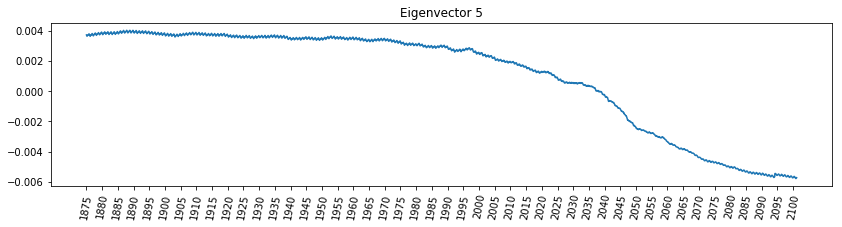

In [48]:
fig = plt.figure(figsize=(14,3))
my_xticks = np.arange(1875, 2101, 5)
ax1 = fig.add_subplot(111)
ax1.set_xticks(np.arange(0, len(v_k[:, 0]), 365*5))
ax1.set_xticklabels(my_xticks, rotation='80')
plt.title('Eigenvector ' + str(5))
plt.plot(v_k[:, 5])
plt.show()

## Getting rid of periodicity

### Smoothing & seasonal decomposition

In [19]:
import pandas as pd

In [31]:
s = pd.Series(v_k[:, 6]/v_k[:, 0])
fig = plt.figure(figsize=(14,3))
ax = plt.subplot(1, 2, 1)
plt.plot(s, color='b')
ax = plt.subplot(1, 2, 2)
f, Pxx_den = signal.periodogram(np.real(s))
#l1 = plt.axvline(x=1/(365*11), color='grey', alpha=0.5) #11y
l2 = plt.axvline(x=1/365, color='r', alpha=0.5) #1y
l3 = plt.axvline(x=1/(365/2), color='g', alpha=0.5) #6m
l4 = plt.axvline(x=1/(365/3), color='y', alpha=0.5) #4m
l5 = plt.axvline(x=1/(365/4), color='b', alpha=0.5) #3m
l6 = plt.axvline(x=1/(365/5), color='pink', alpha=0.5) #2.4m
l7 = plt.axvline(x=1/(365/6), color='orange', alpha=0.5) #2m
l8 = plt.axvline(x=1/(365/12), color='black', alpha=0.5)
plt.loglog(f, Pxx_den)

NameError: name 'pd' is not defined

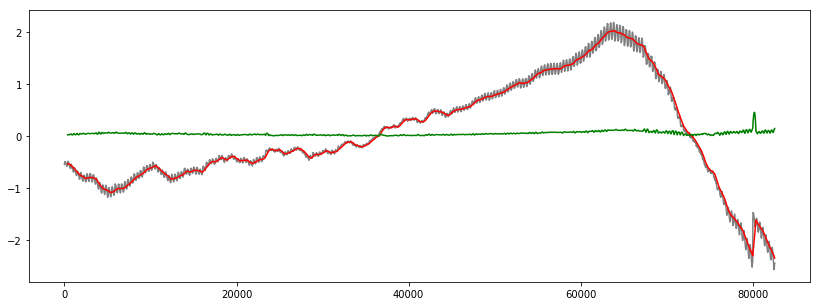

In [25]:
fig = plt.figure(figsize=(14,5))
rolling = s.rolling(window=365*1)
m = rolling.mean()
std = rolling.std()
plt.plot(s, color='grey')
plt.plot(m, color='r')
plt.plot(std, color='g')

In [26]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

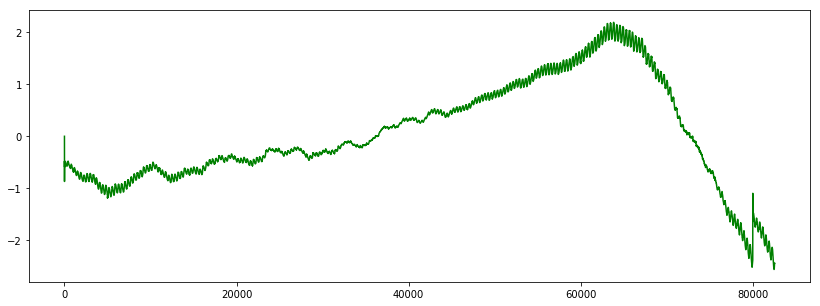

In [27]:
model = ExponentialSmoothing(s, trend='add', seasonal=None)
#model._index = pd.to_datetime(train.index)

fit1 = model.fit()
#pred1 = fit1.forecast(9)
fit2 = model.fit(smoothing_level=.2)
#pred2 = fit2.forecast(9)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(fit2.fittedvalues, color='g')

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [29]:
s.index = pd.DatetimeIndex(freq='d', start='1875-01-01', periods=len(s))
result = seasonal_decompose(s+3.0, model='multiplicative')

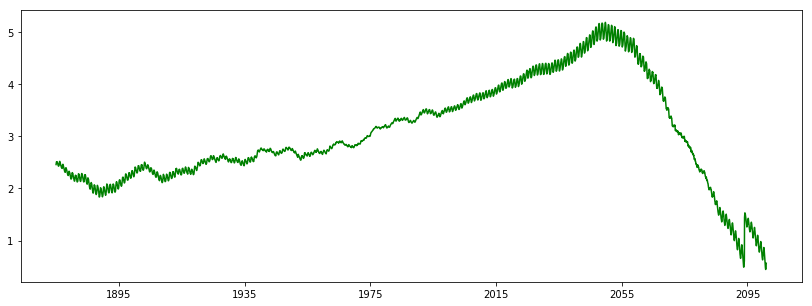

In [30]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(result.trend[:], color='g')

### Lowpass filter

In [19]:
from scipy import signal

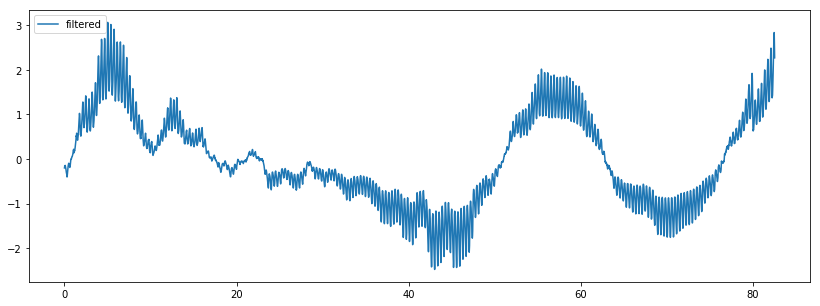

In [46]:
fs = 1000 # Sampling frequency
fc = 30 # Cut-off frequency of the filter
t = np.arange(len(s)) / fs
w = fc / (fs / 2) # Normalize the frequency
b, a = signal.butter(5, w, 'low')
output = signal.filtfilt(b, a, s)

fig, ax = plt.subplots(figsize=(14, 5))
plt.plot(t, output, label='filtered')
plt.legend()
plt.show()

### HP filter

In [31]:
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.filters.cf_filter import cffilter

In [32]:
#Ravn and Uhlig suggest using a value of 6.25 (1600/4**4) for annual data 
#and 129600 (1600*3**4) for monthly data.

cycle, trend = hpfilter(s, 1600*90**4)

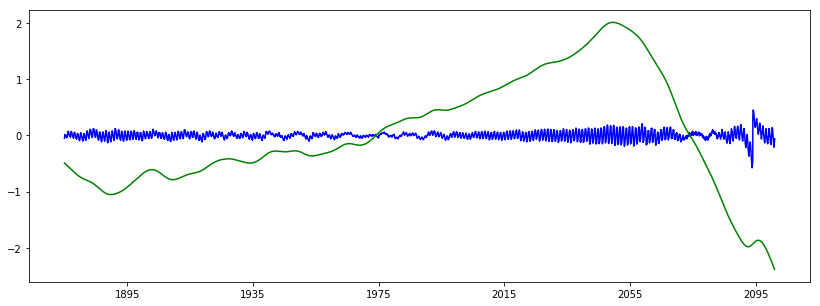

In [33]:
fig, ax = plt.subplots(figsize=(14, 5))
plt.plot(cycle, color='b')
plt.plot(trend, color='g')
plt.show()

In [34]:
cf_cycles, cf_trend = cffilter(s, low=1.5*365, high=8*365)

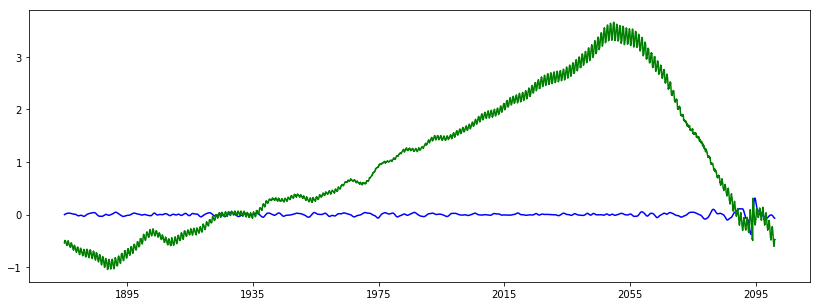

In [35]:
fig, ax = plt.subplots(figsize=(14, 5))
plt.plot(cf_cycles, color='b')
plt.plot(cf_trend, color='g')
plt.show()

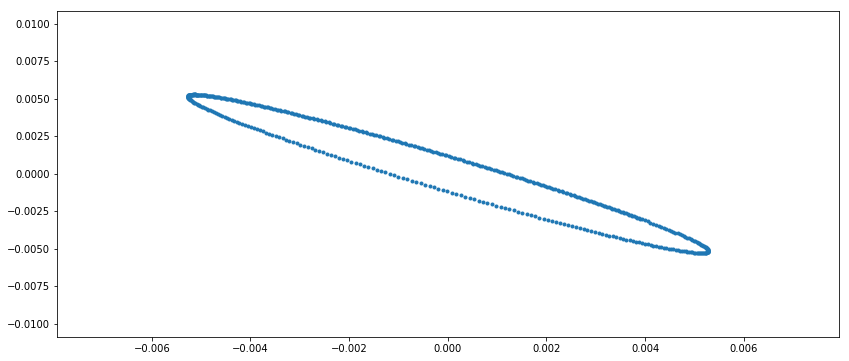

In [36]:
fig = plt.figure(figsize=(14,6))
plt.scatter(x=v_k[:500, 1], y=v_k[:500, 2], marker='.')

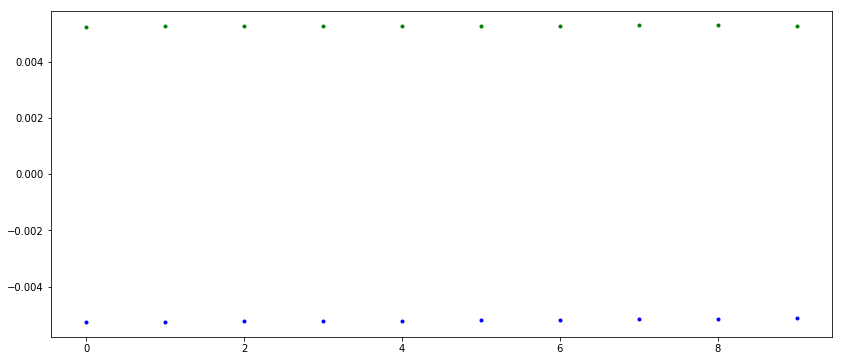

In [38]:
fig = plt.figure(figsize=(14,6))
plt.plot(v_k[:10, 1], '.', color='b')
plt.plot(v_k[:10, 2], '.', color='g')

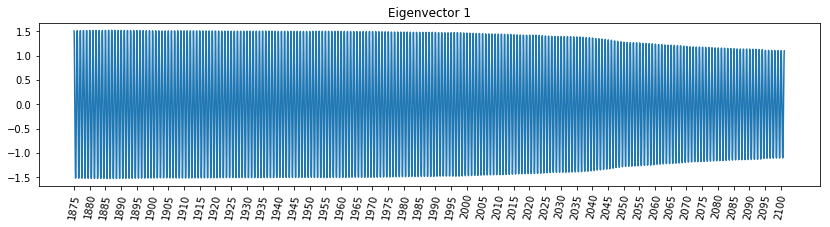

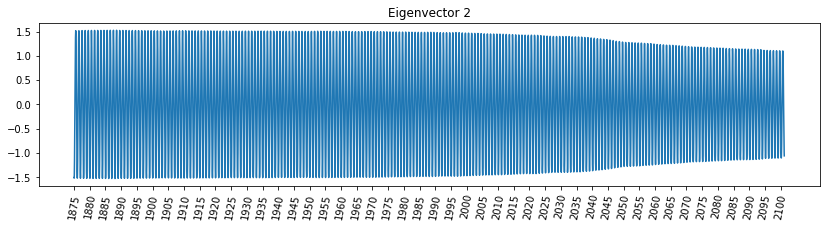

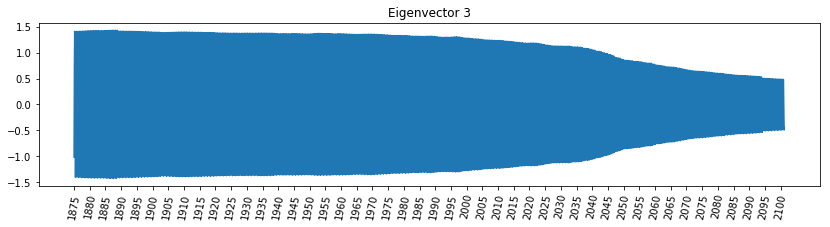

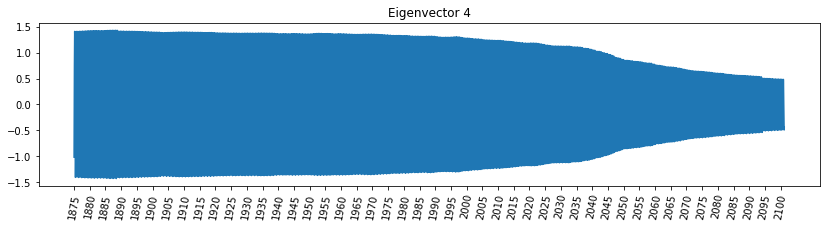

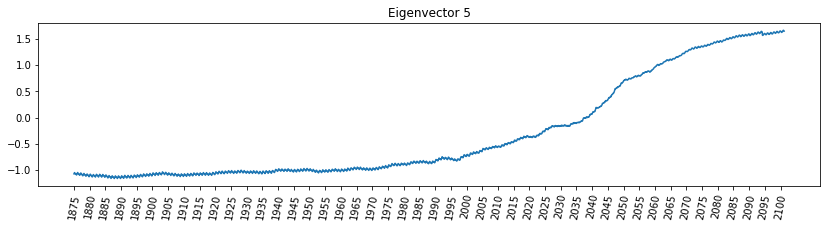

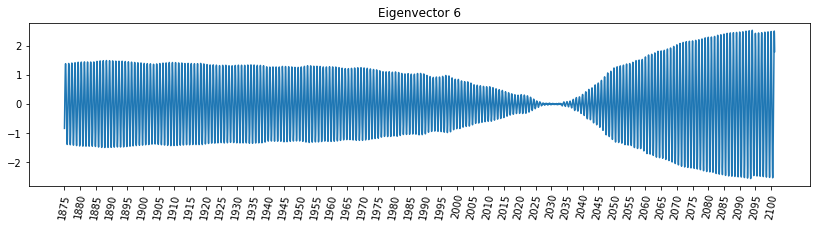

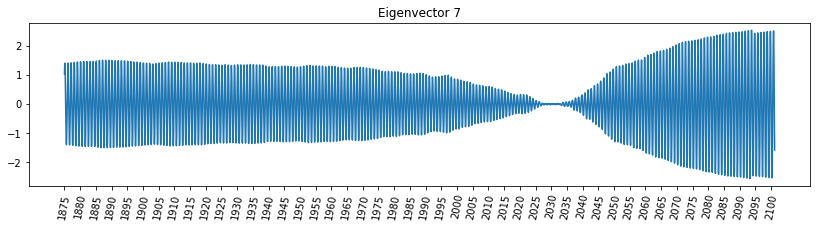

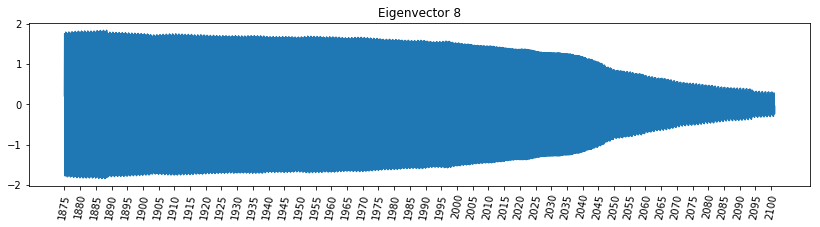

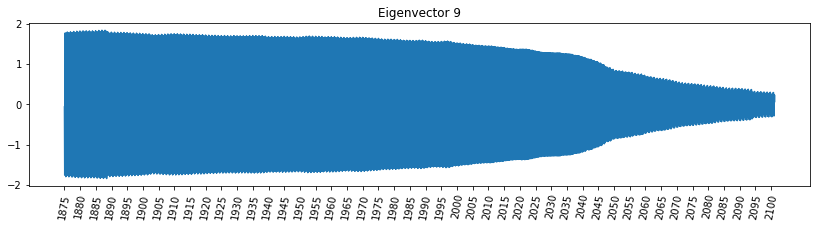

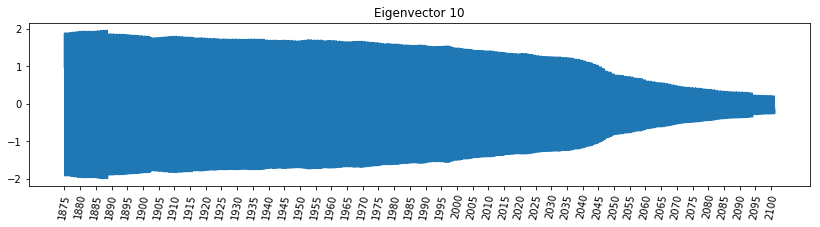

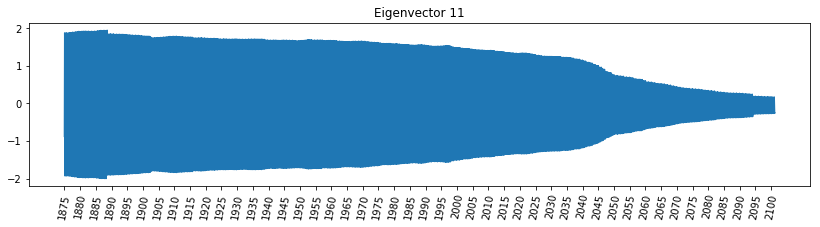

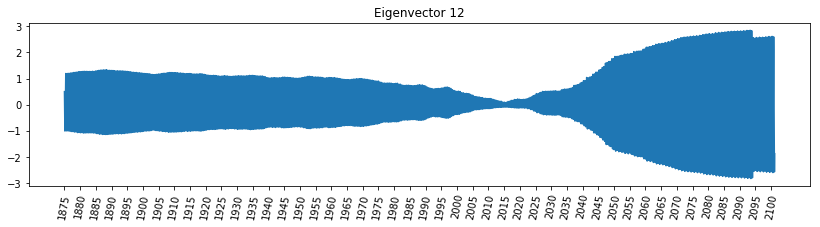

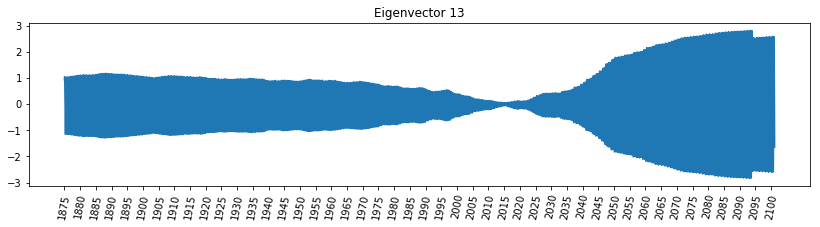

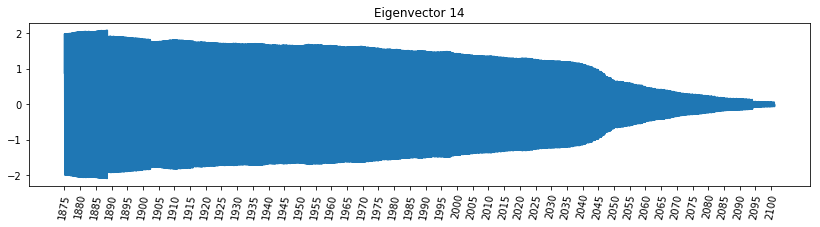

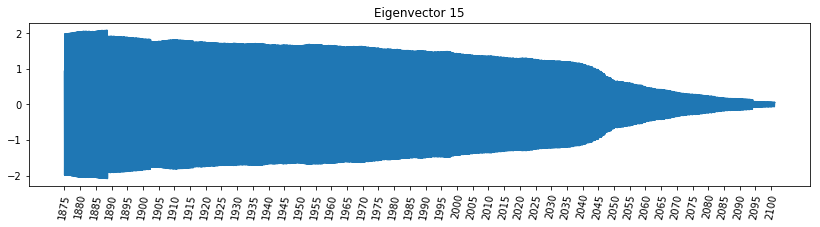

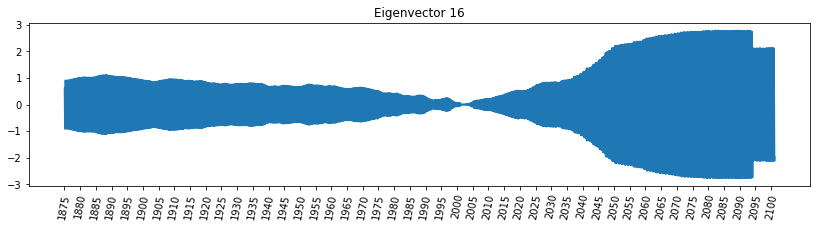

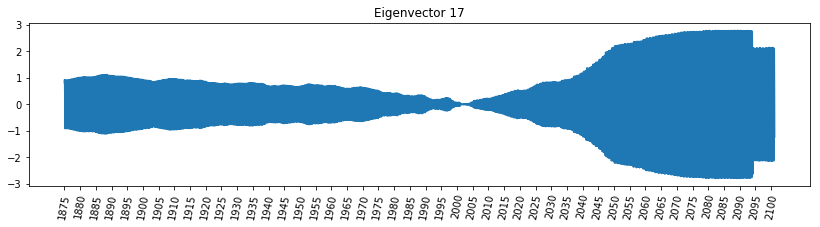

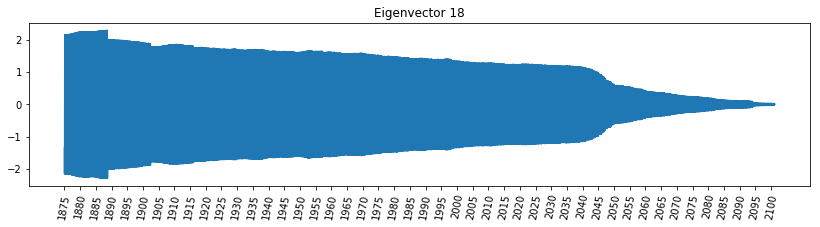

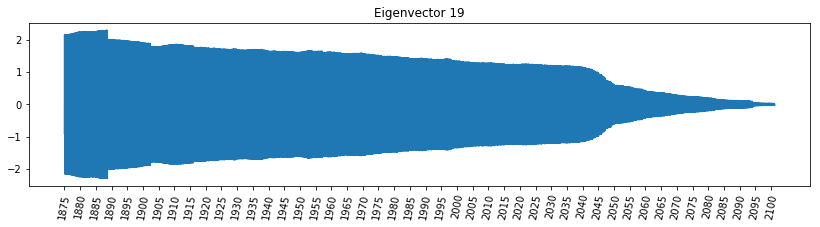

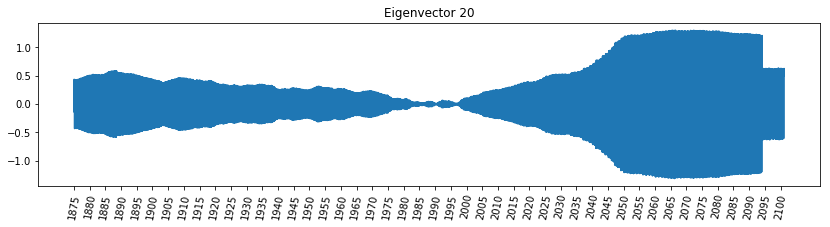

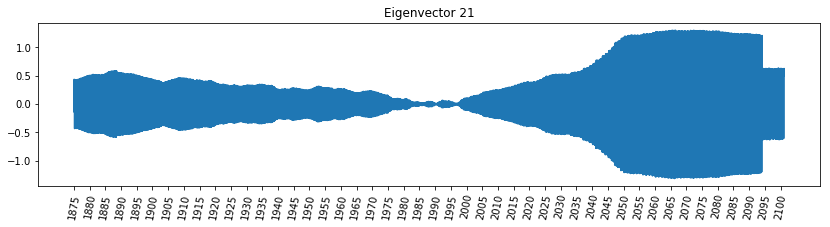

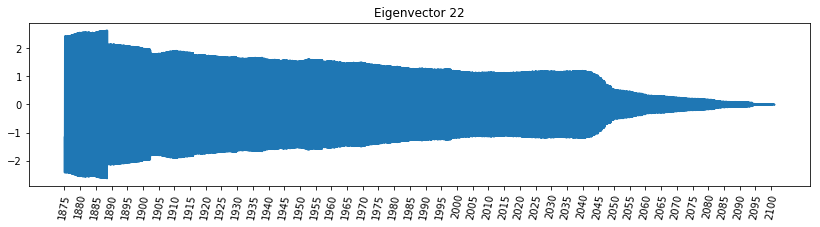

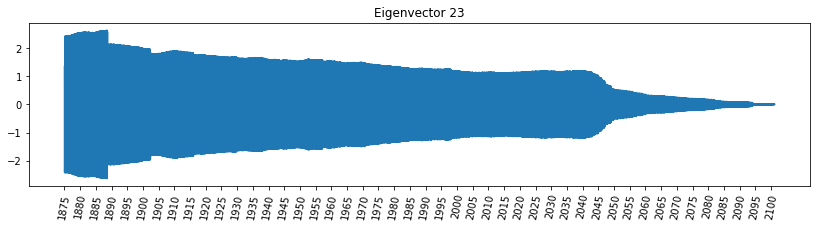

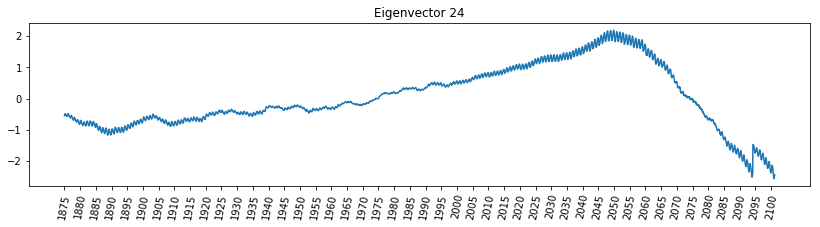

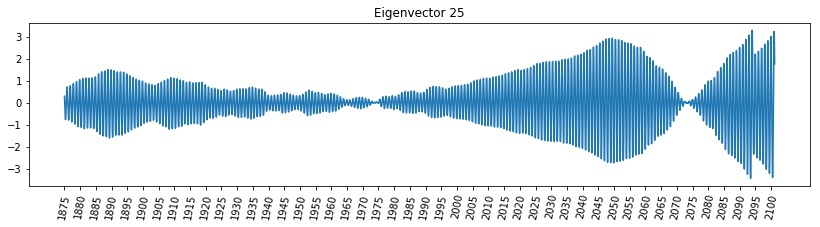

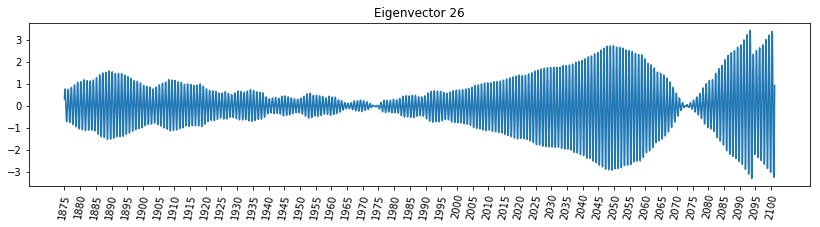

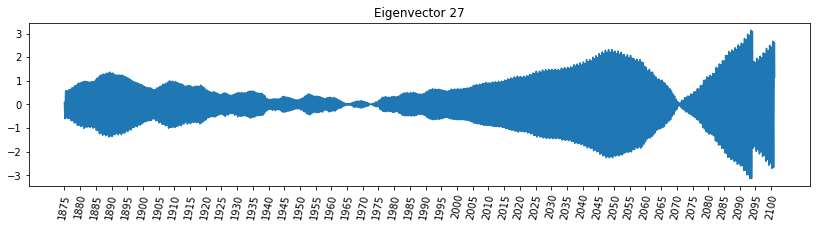

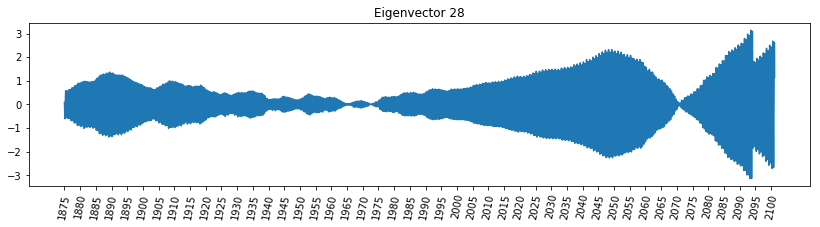

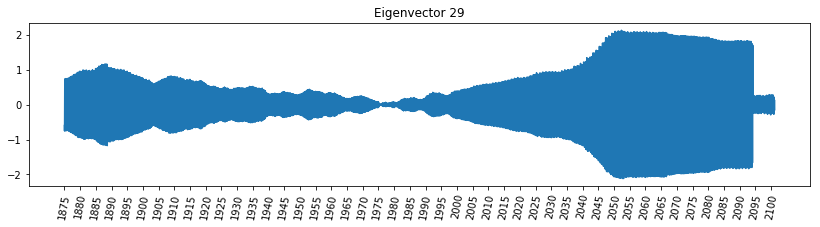

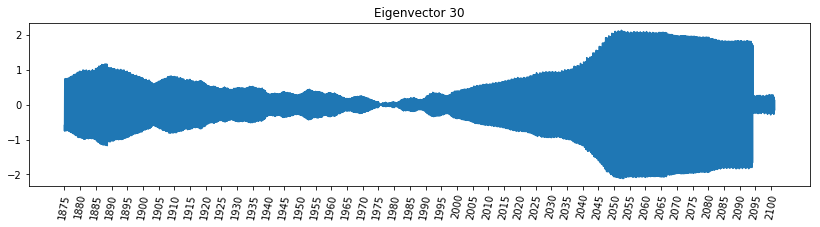

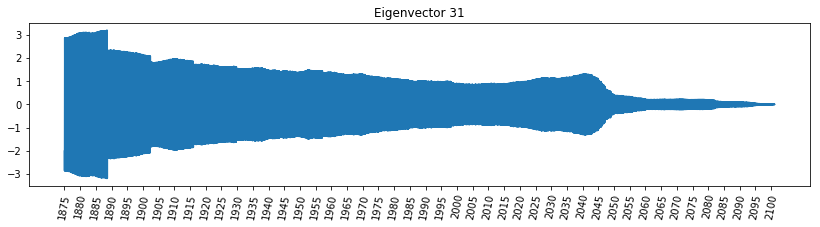

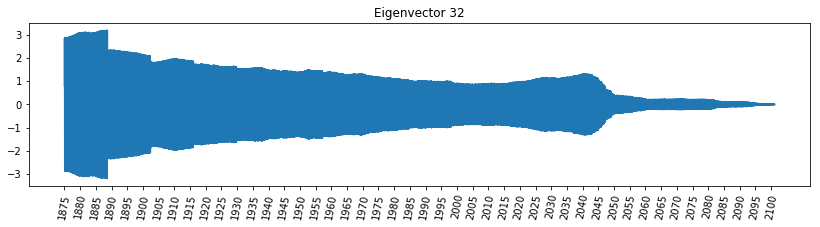

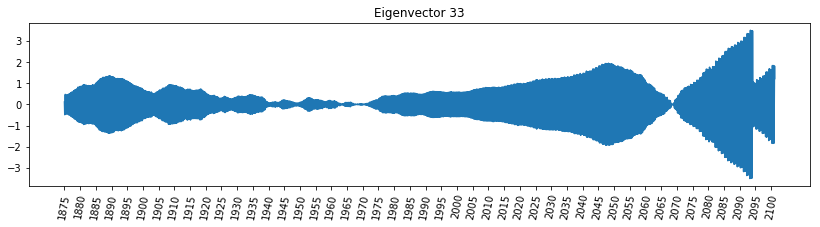

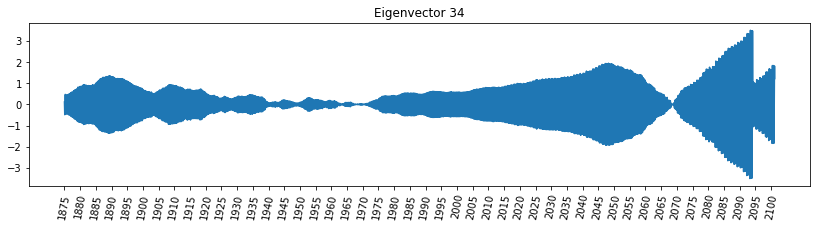

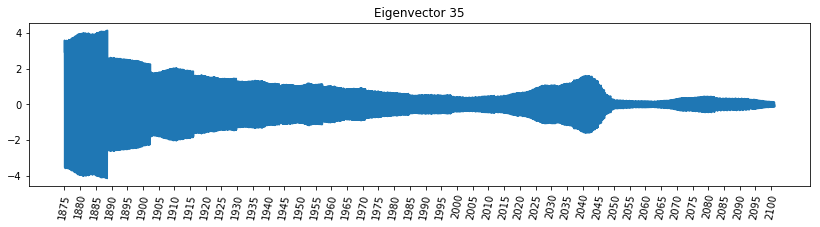

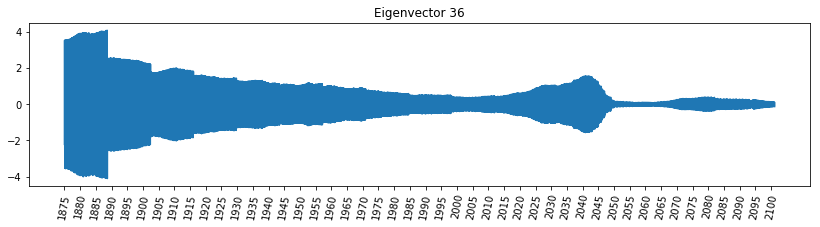

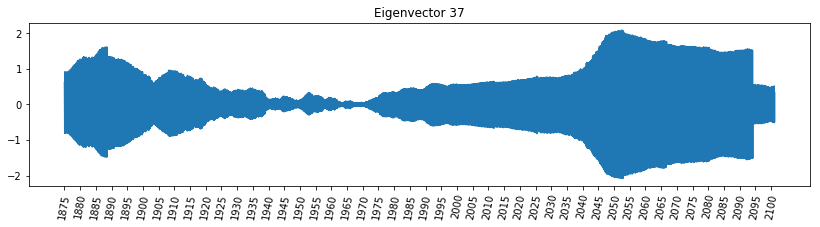

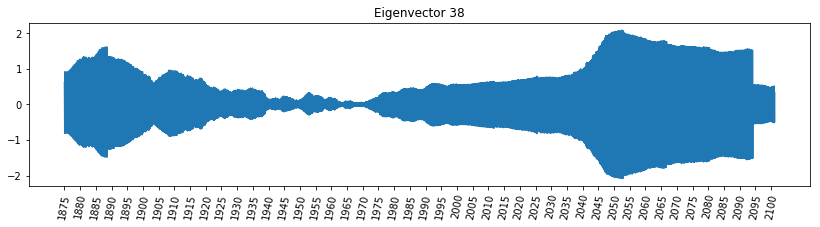

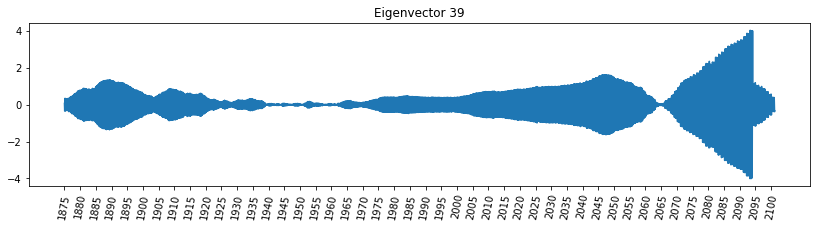

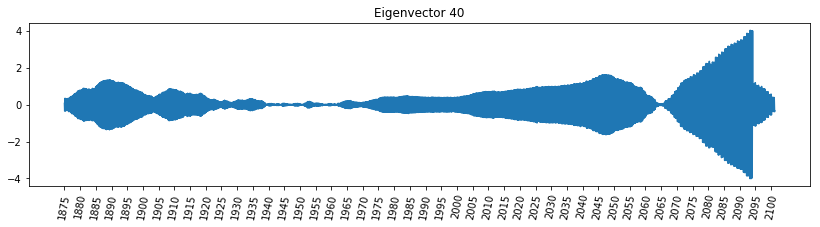

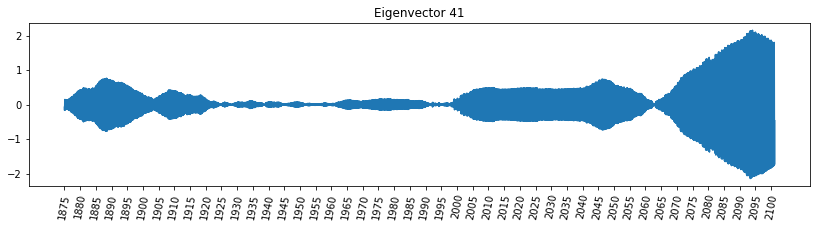

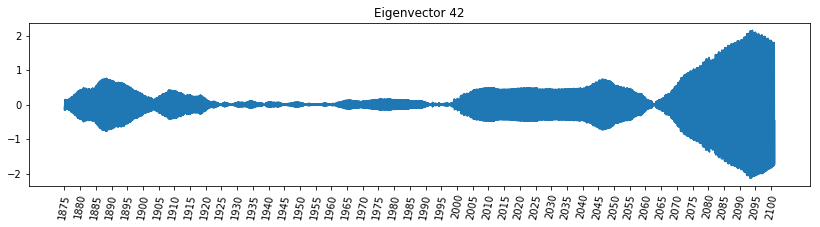

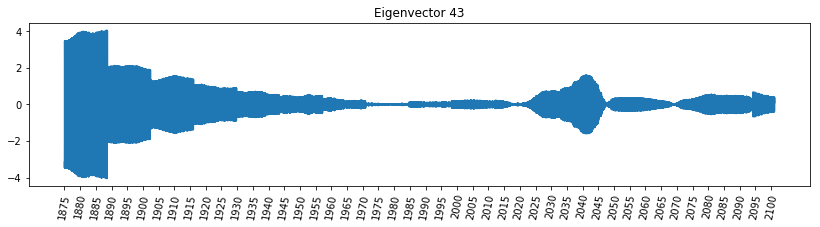

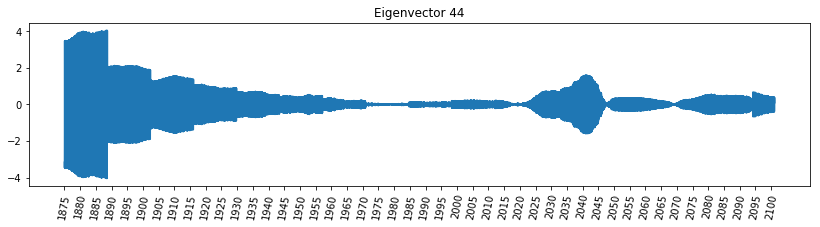

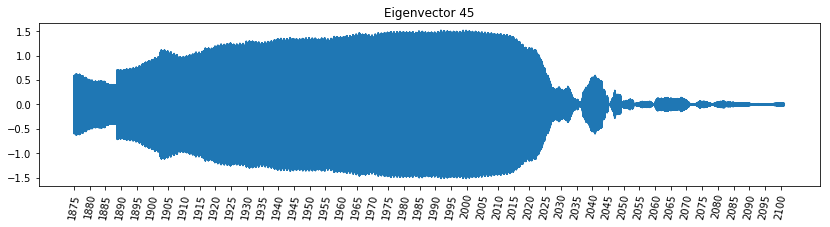

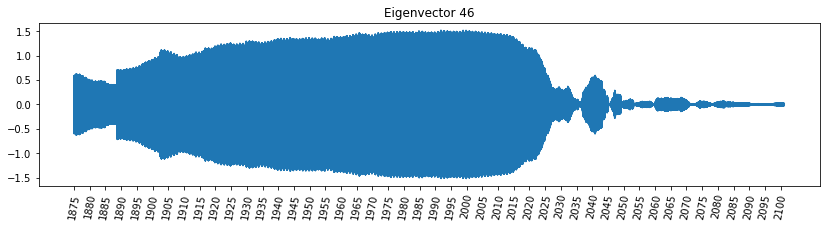

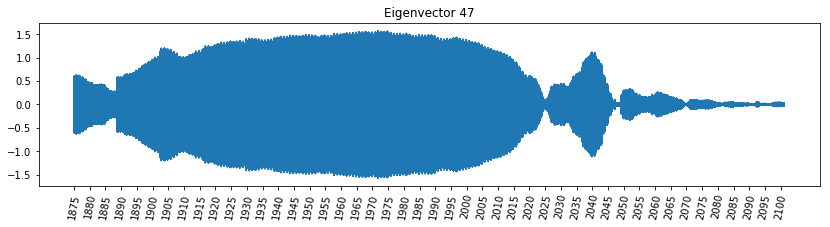

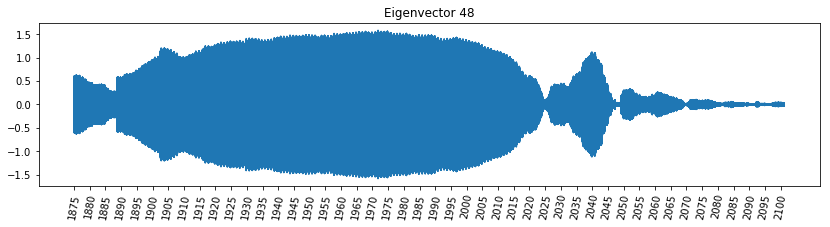

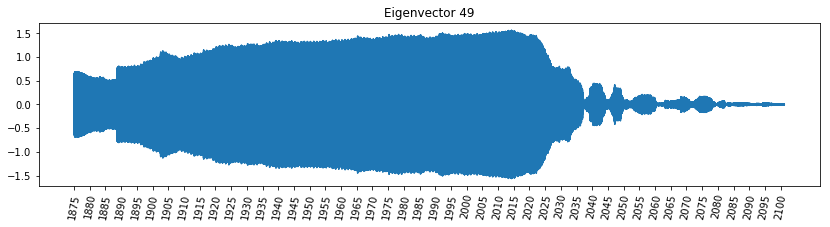

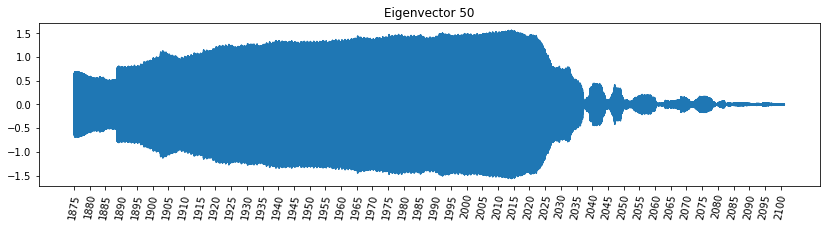

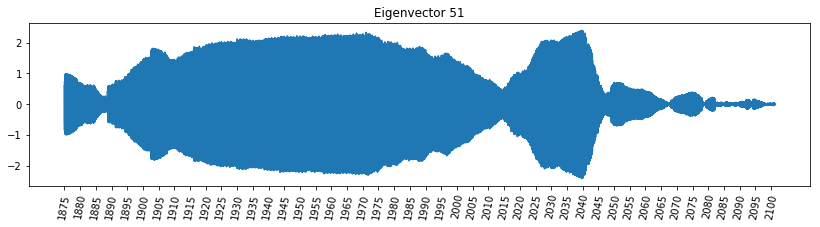

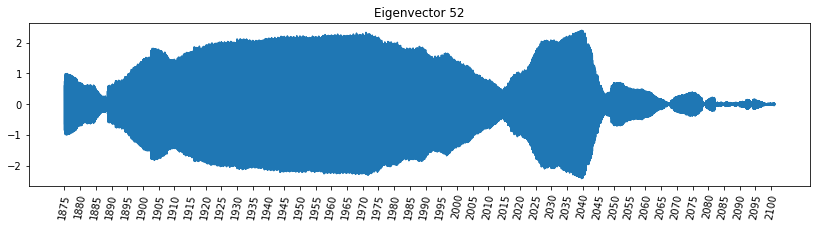

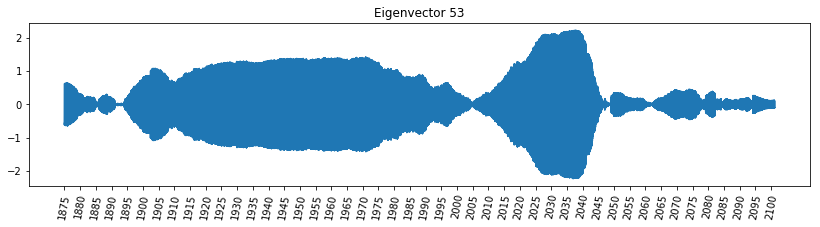

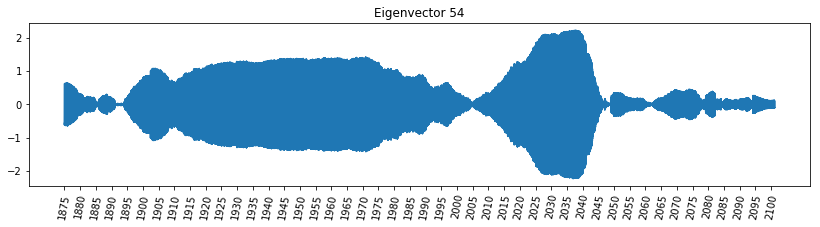

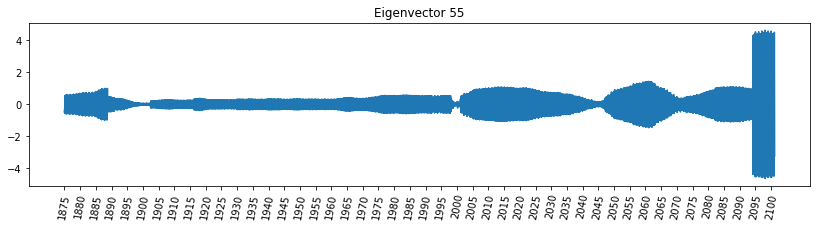

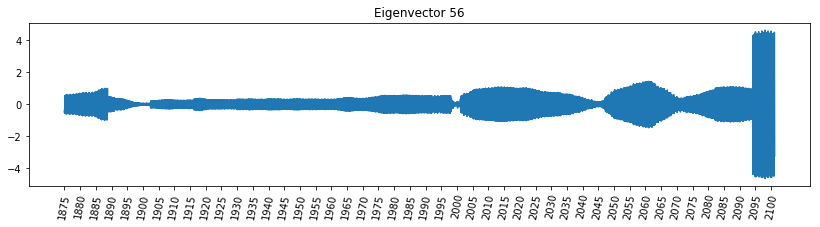

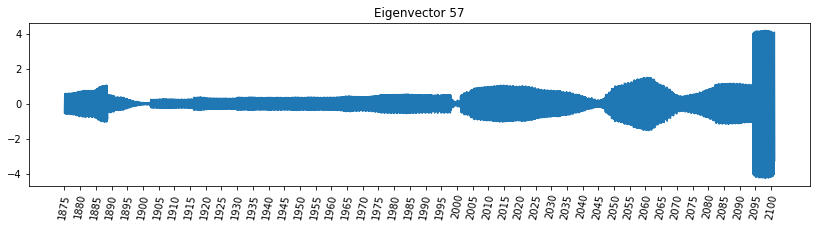

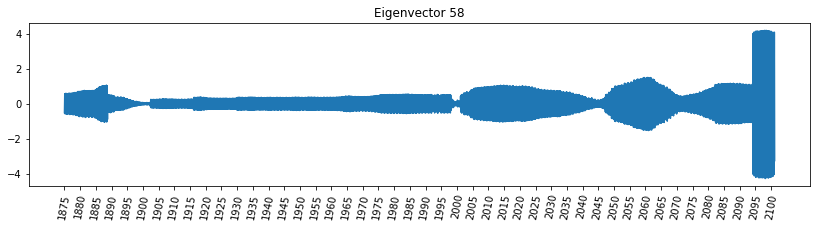

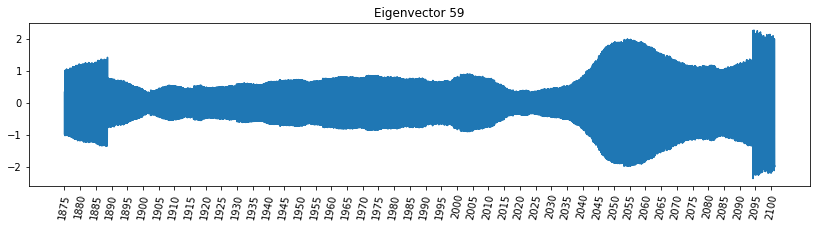

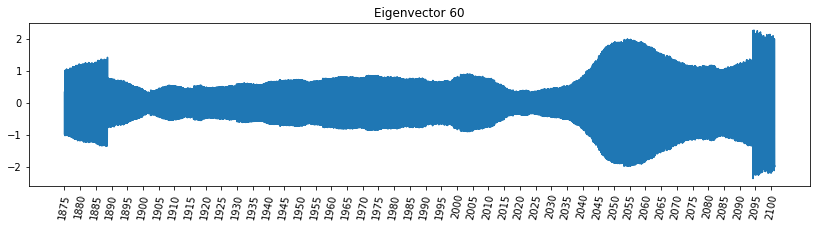

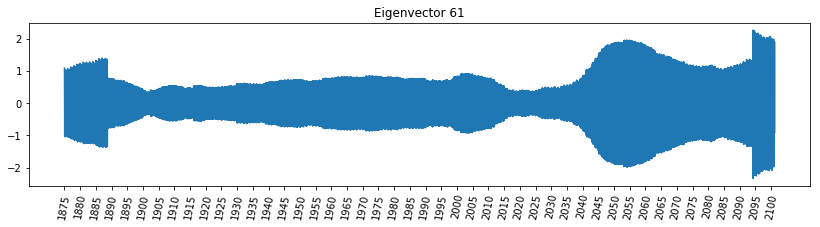

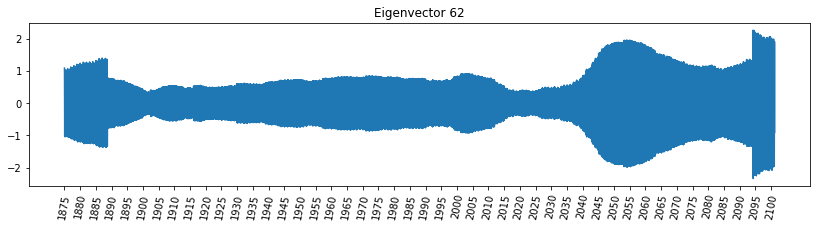

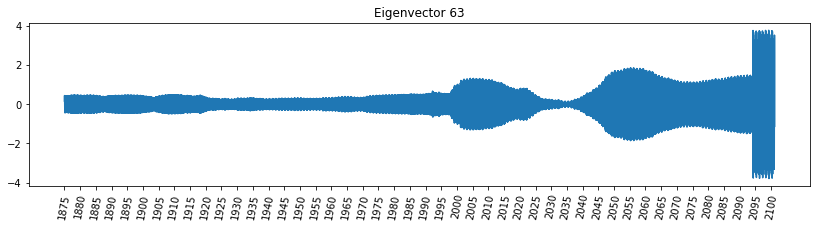

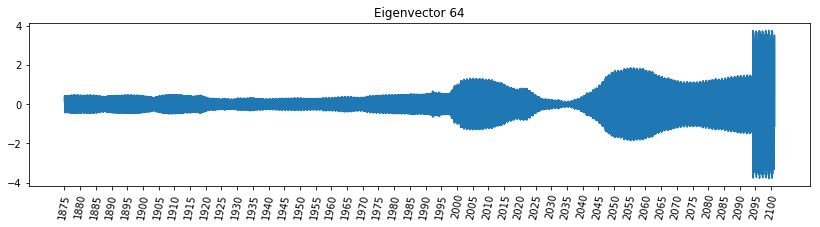

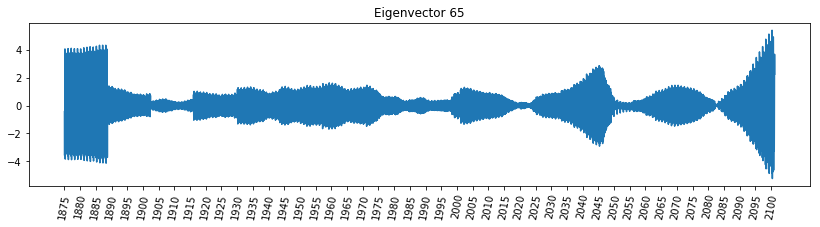

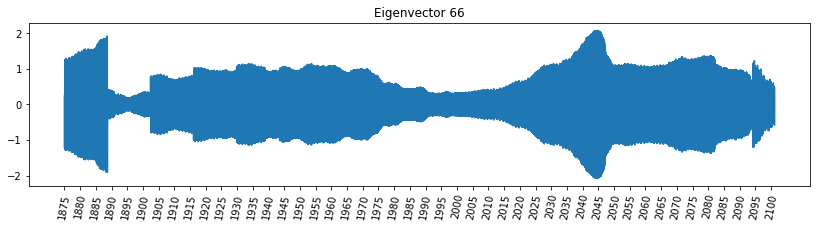

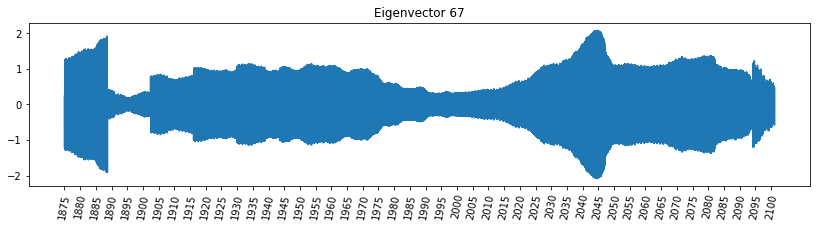

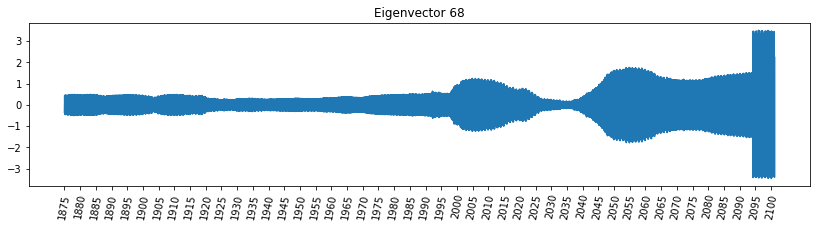

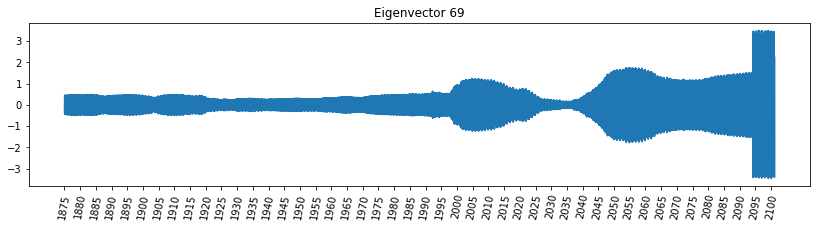

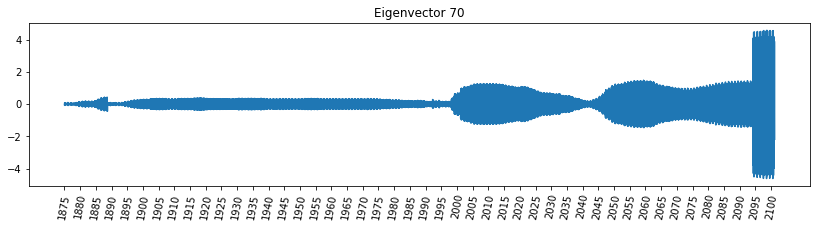

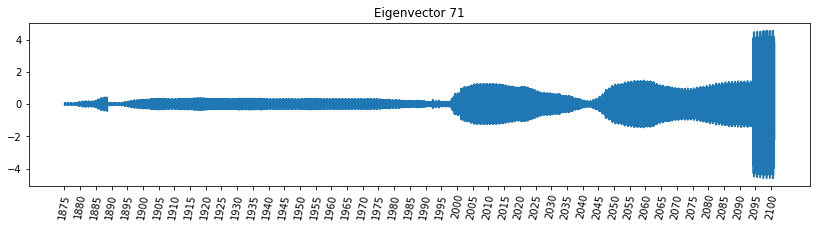

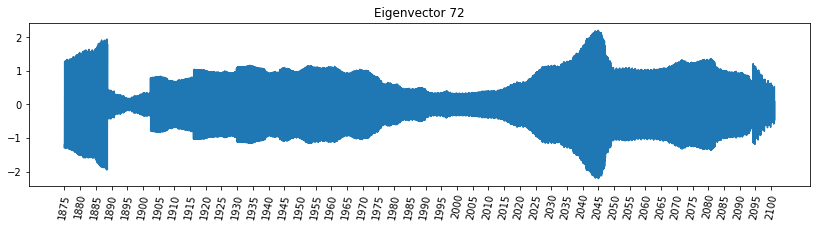

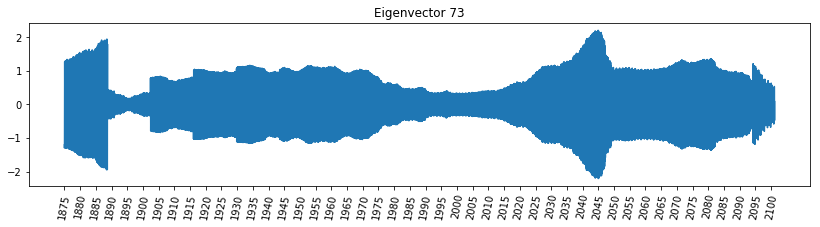

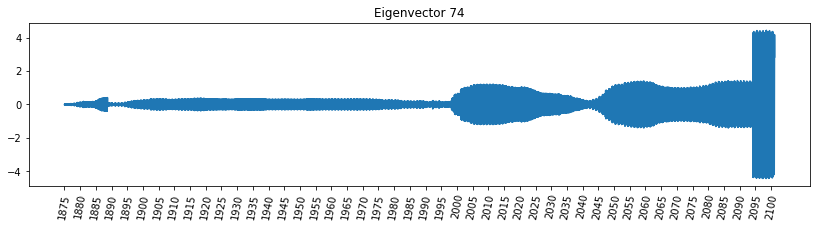

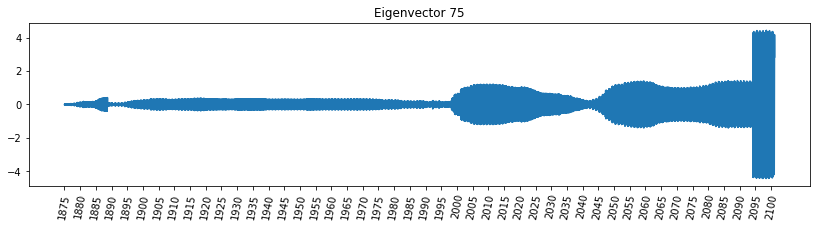

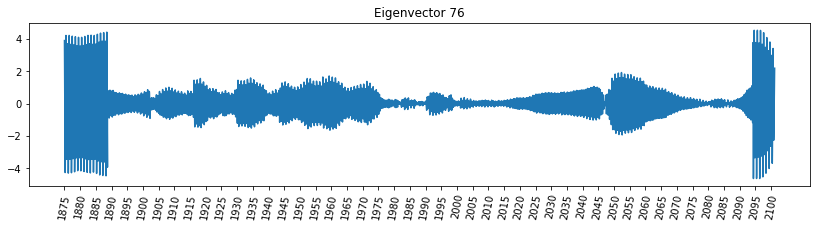

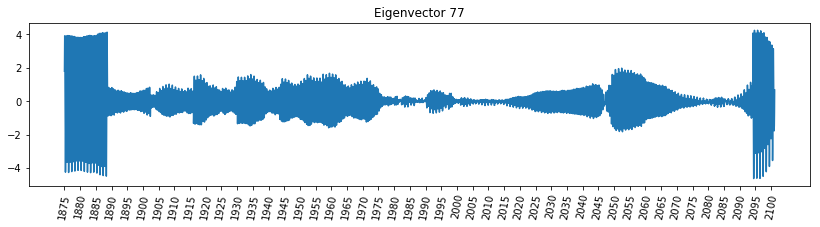

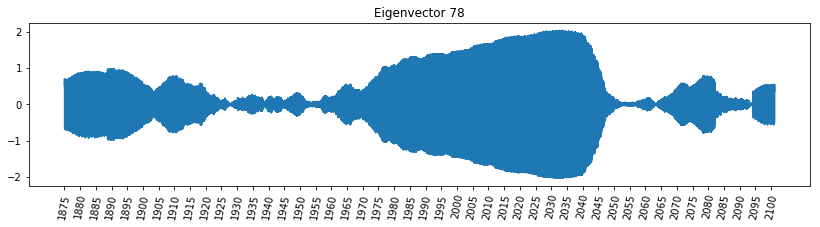

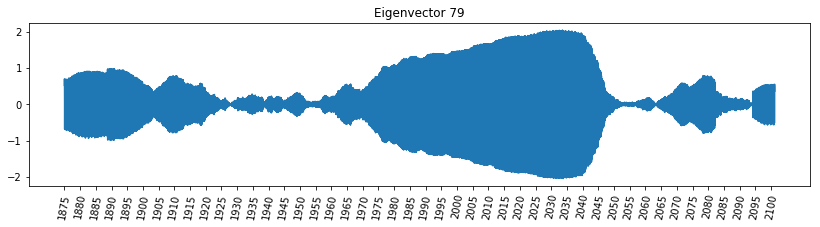

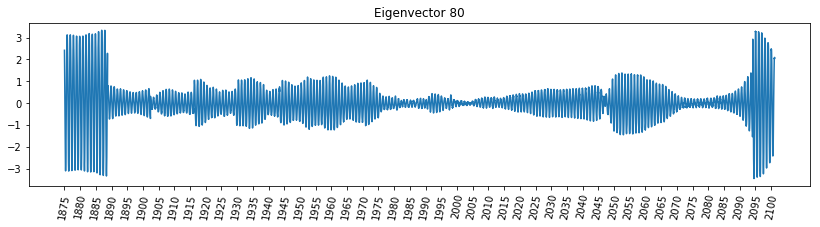

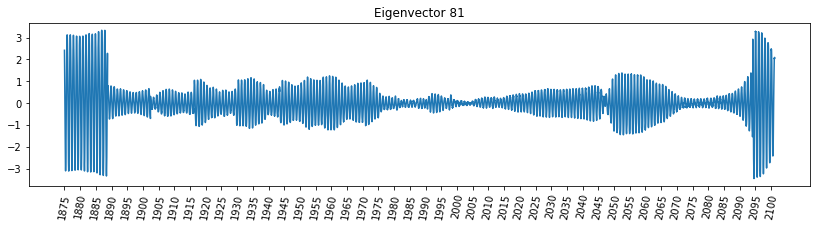

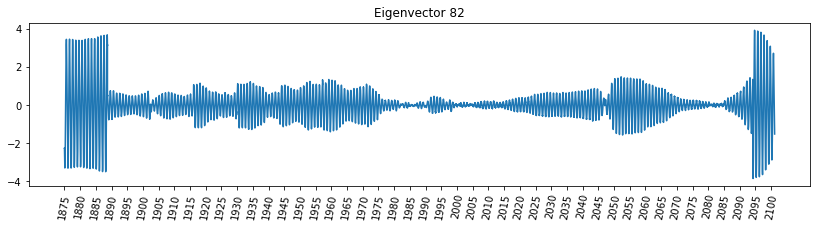

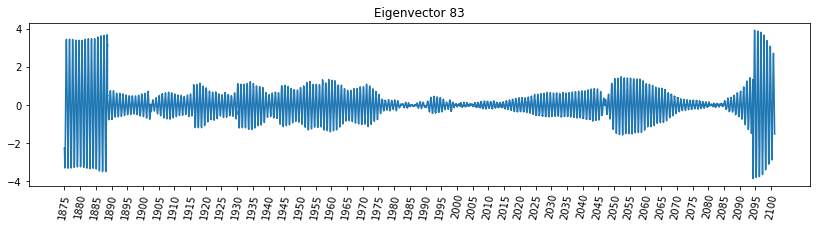

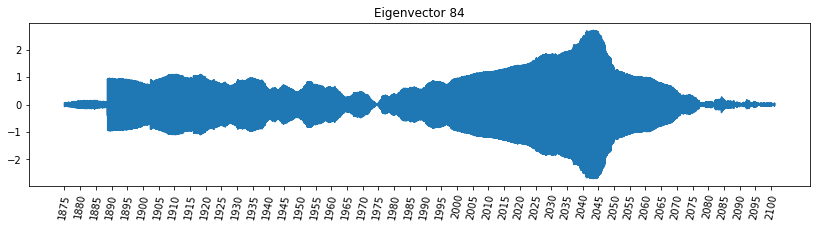

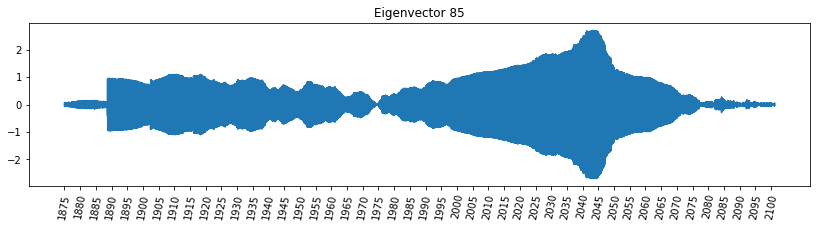

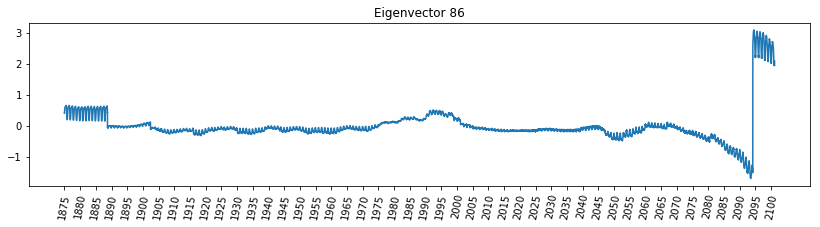

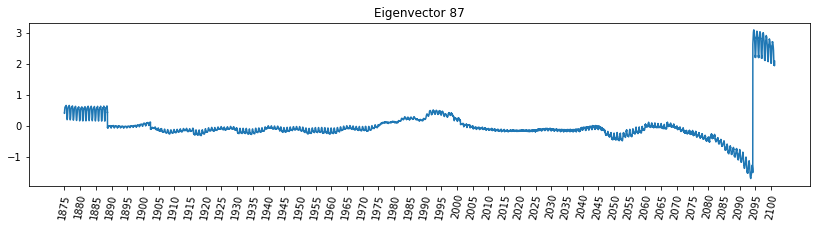

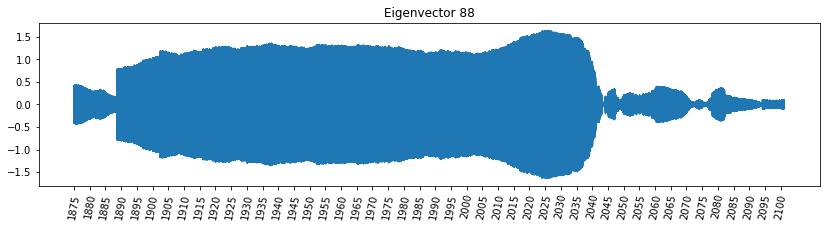

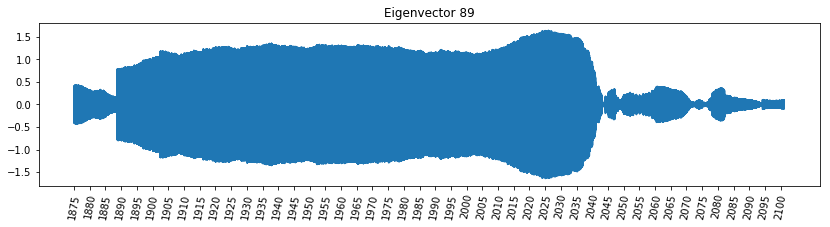

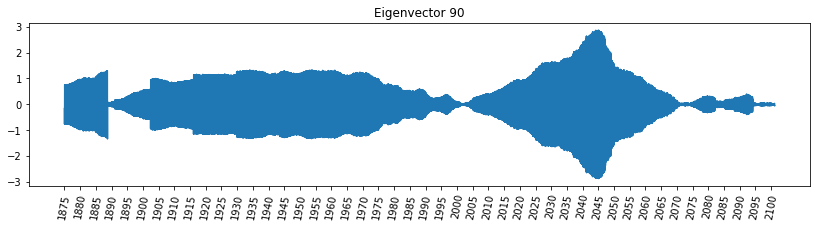

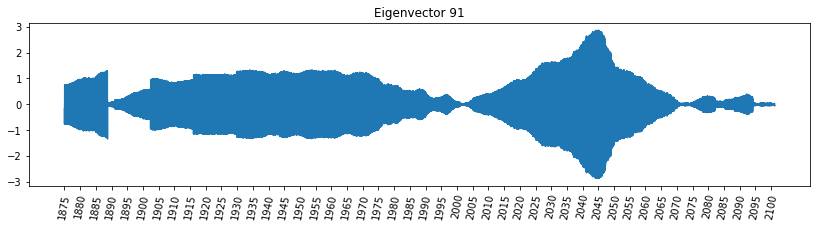

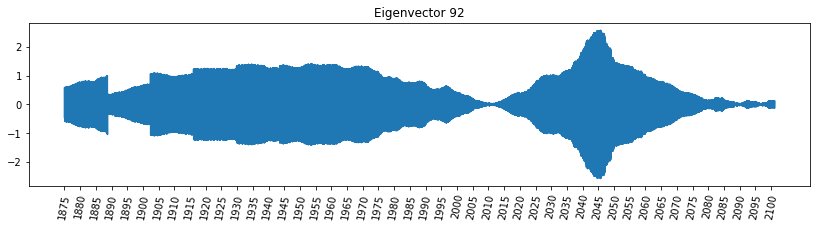

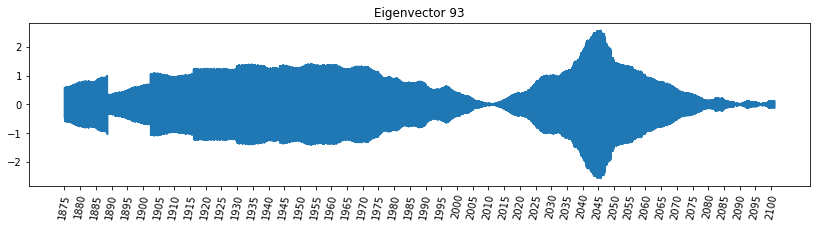

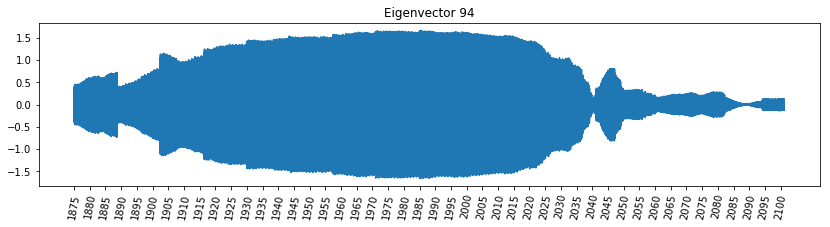

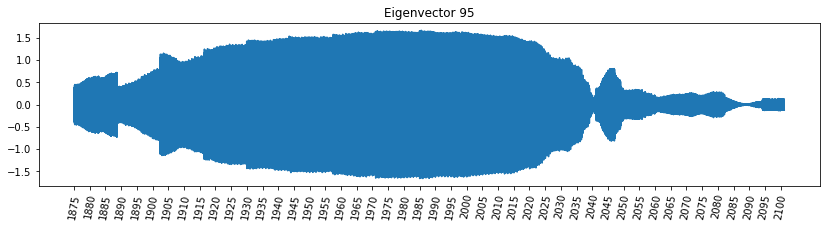

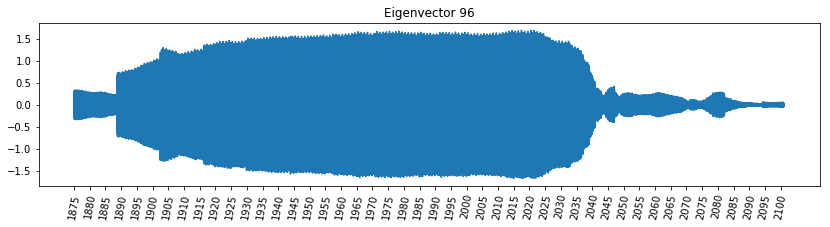

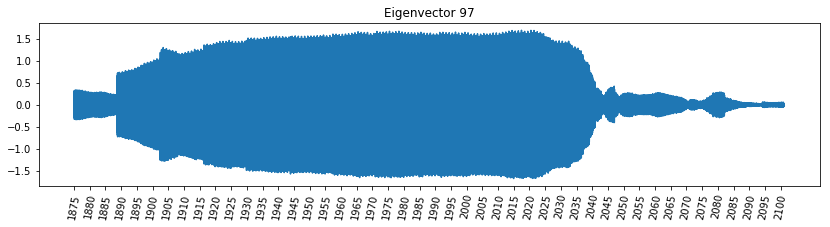

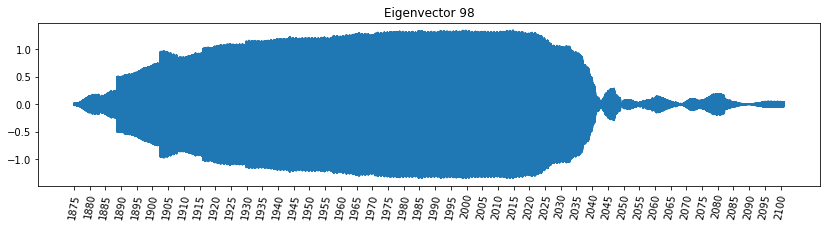

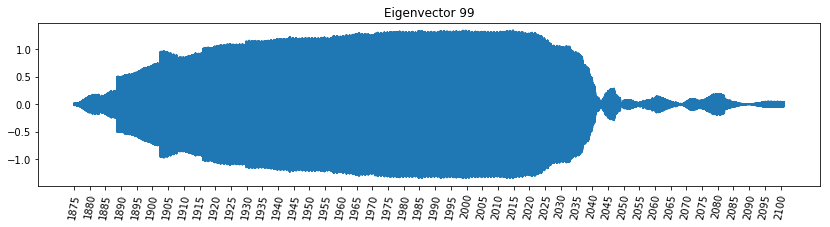

In [21]:
for i in range(1, 100):
    fig = plt.figure(figsize=(14,3))
    my_xticks = np.arange(1875, 2101, 5)
    ax1 = fig.add_subplot(111)
    ax1.set_xticks(np.arange(0, len(v_k[:, 0]), 365*5))
    ax1.set_xticklabels(my_xticks, rotation='80')
    plt.title('Eigenvector ' + str(i))
    plt.plot(v_k[:, i]/v_k[:, 0])
    plt.show()

## Recontructions

In [ ]:
# Load original data for projection
d_data = np.load('avg_MPI_ESM.npy')
d_data = d_data.reshape(d_data.shape[0], d_data.shape[1]*d_data.shape[2])   
anomalies = d_data - np.mean(d_data, axis=0)
anomalies = np.reshape(anomalies, (11323, 72, 144))

In [87]:
chosen_vec = v_k[:, 5]
size_vec = len(chosen_vec)
resized_data = anomalies[(anomalies.shape[0] - size_vec):,:]
resized_data = resized_data.reshape(resized_data.shape[0], resized_data.shape[1]*resized_data.shape[2])
X = resized_data.T
s_pattern = X @ chosen_vec
spp = np.reshape(s_pattern,(-1, 72*144))
vec = np.reshape(np.real(chosen_vec), (-1, size_vec))
Y = spp.T @ vec
Z = Y.T
Z = np.reshape(Z, (size_vec, 72, 144))

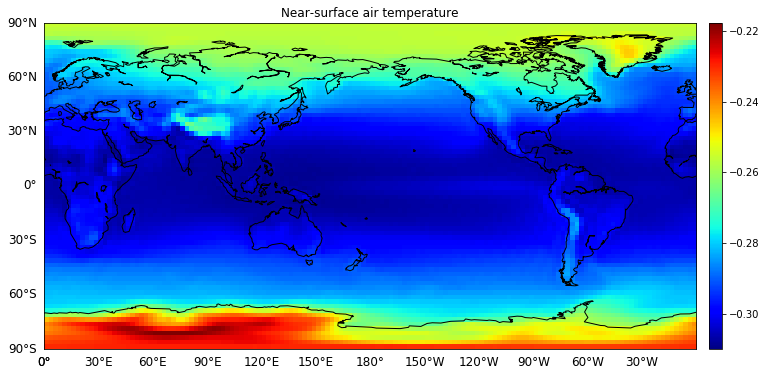

In [90]:
fig = plt.figure(figsize=(16,6))
long = [0, 360]
lat = [-90, 90]


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    map = Basemap(projection = 'cyl', llcrnrlat = lat[0], llcrnrlon = long[0], urcrnrlat = lat[1], urcrnrlon = long[1])
    map.drawcoastlines()
    map.drawparallels( np.arange(-90,90.01,30.0), labels = [1,0,0,0], fontsize = 12, linewidth = 0)
    map.drawmeridians( np.arange(0.,360.,30.), labels = [0,0,0,1], fontsize = 12, linewidth = 0)

    h = map.imshow(Z[59520, :], cmap = 'jet', interpolation = 'none', animated = True)
    #m = max(max(abs(Z[:, :])))
    #plt.clim(-5, 5)
    map.colorbar(h, size = "2%")#, pad="40%", ticks = range(cmin, cmax + 1, cint))
    plt.title("Near-surface air temperature")

In [ ]:
test_mov = Z[1::30, :]
a = helper.make_animation(test_mov, 317)

In [ ]:
helper.save_as_vid(a, 'Volcanic_cycle.mp4')

In [ ]:
helper.load_vid('Volcanic_cycle.mp4')